In [1]:
%matplotlib notebook
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

import traceback, functools, pprint, math, random

import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d

from IPython.display import HTML

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

<IPython.core.display.Javascript object>


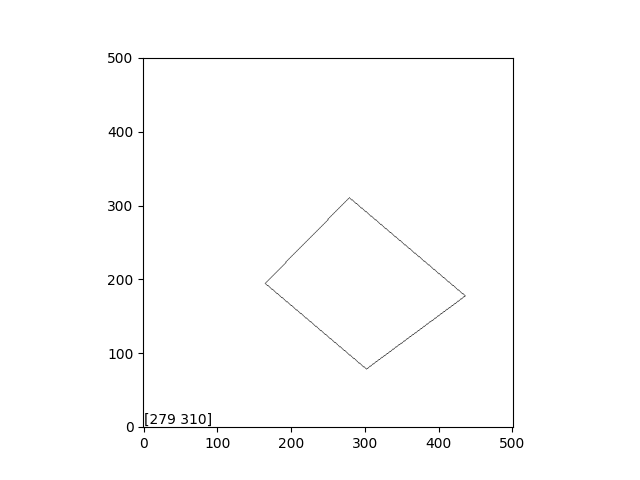

In [3]:
nx, ny = 501, 501

plt.figure()
img = np.full((nx, ny, 3), 255, dtype='uint8')

plt.ion()

im = plt.imshow(img, origin='lower')
fig = plt.gcf()
ax = plt.gca()

text=ax.text(0,0, "", va="bottom", ha="left")

points = np.array([], dtype='uint8').reshape((-1, 2))
snap_threshold = 10

@print_errors_to_stdout
def on_press(event):
    global points
    
    if plt.isinteractive():
        # debug printout
        # tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        # text.set_text(tx)

        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) > 1 and all(np.abs(point - points[0]) < snap_threshold):
            point = points[0]
            plt.ioff()
        
        points = np.vstack((points, point))
        text.set_text(f'{point}')

        if len(points) > 1:
            n = len(points)
            cv2.line(img, tuple(points[n-2]), tuple(points[n-1]), (0, 0, 0), thickness=1)

        im.set_data(img)

        plt.draw()

@print_errors_to_stdout
def on_move(event):
    if plt.isinteractive() and event.inaxes is not None:
        tmp_img = np.copy(img)
        
        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) >= 1:
            n = len(points)
            
            if all(np.abs(point - points[0]) < snap_threshold):
                point = points[0]
                
            cv2.line(tmp_img, tuple(points[n-1]), tuple(point), (0, 0, 0), thickness=1)
            
        im.set_data(tmp_img)

        plt.draw()
        
cid = fig.canvas.mpl_connect('button_press_event', on_press)
cid = fig.canvas.mpl_connect('motion_notify_event', on_move)

In [4]:
def centroid(points):
    """Returns the centroid of a polygon."""
    n = len(points)
    def next(i):
        return (i + 1) % n
    shoelace = [points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)]
    list_x = [(points[i, 0] + points[next(i), 0])*shoelace[i] for i in range(n)]
    list_y = [(points[i, 1] + points[next(i), 1])*shoelace[i] for i in range(n)]
    
    const = 1/(6*signed_area(points))
    C_x = const * sum(list_x)
    C_y = const * sum(list_y)
    
    return C_x, C_y
    
def signed_area(points):
    """Returns the signed area of a polygon as described by the shoelace formula."""
    n = len(points)
    def next(i):
        return (i + 1) % n
    
    res = sum([points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)])
    return res/2

def scale_polygon(points, max_dim=100):
    """
    Scales the polygon so that the largest dimension is approximately max_dim units

    Units are retained as integers, so there is chance for slight deviations in the points.
    """
    width = max(points[:, 0]) - min(points[:, 0])
    height = max(points[:, 1]) - min(points[:, 1])
    
    scale = max_dim / max(width, height)
    
    return np.around(points * scale).astype(np.int32)

def scale_and_center_polygon(points):
    """
    Convenience function to scale a polygon (so that all polygons are approximately
    the same scale in terms of their height or width) and center the polygon so that
    its centroid is approximately located at (0, 0). Because all operations are kept
    as integers, the centroid is likely to be within 1 unit of (0, 0) but not exactly
    there.
    """
    points = scale_polygon(points)

    C_x, C_y = centroid(points)

    points[:, 0] -= round(C_x)
    points[:, 1] -= round(C_y)
    
    return points

def plot_function(piecewise_func, period, domain=(0, 2*np.pi), extrema=True):
    """Convenience function to plot a diameter or radius function. """
    piecewise_func = generate_range(piecewise_func, period, domain=domain)
    diameter_func = generate_callable(piecewise_func)

    x = np.linspace(*domain, 1000)
    y = np.array([diameter_func(t) for t in x])
    
    steps = round((domain[1]-domain[0])/(np.pi/2)) + 1
    
    plt.figure()
    plt.plot(x, y)
    plt.xticks(np.linspace(*domain, steps))
    
    if extrema:
        maxima, minima = find_extrema(piecewise_func, domain=domain)

        for m in maxima:
            plt.plot([m, m], [0, diameter_func(m)], color='r')
        for m in minima:
            plt.plot([m, m], [0, diameter_func(m)], color='g')

    plt.show()
    
def plot_transfer_function(piecewise_transfer_func, domain=(0, 2*np.pi)):
    """Convenience function to plot a transfer function (i.e. squeeze, push, or push-grasp function)."""
    transfer_callable = make_transfer_callable(piecewise_transfer_func, domain=domain)
    
    x = np.linspace(*domain, 1000)
    y = np.array([transfer_callable(t) for t in x])
    
    steps = round((domain[1]-domain[0])/(np.pi/2)) + 1
    
    plt.figure()
    plt.plot(x, y)
    plt.xticks(np.linspace(*domain, steps))
    plt.yticks(np.linspace(*domain, steps))
    plt.show()

In [5]:
points = scale_and_center_polygon(points[:-1])
# points = scale_and_center_polygon(points)
points

# points = np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)]) # House shape
points = np.array([(-42, -41), (48, -41), (39, 25), (-34, 59)]) # 4gon in paper
# points = np.array([(-42, -42), (42, -42), (42, 42), (-42, 42)]) # Square box

<IPython.core.display.Javascript object>


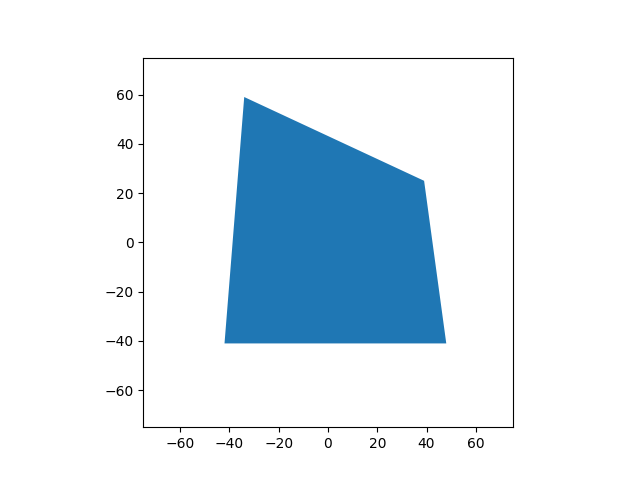

In [6]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.gca().set_aspect("equal")
plt.xlim((-75, 75))
plt.ylim((-75, 75))
plt.show()

In [7]:
def triangle_signed_area(p1, p2, p3):
    """
    Returns the twice the signed area of a triangle defined by the points (p1, p2, p3).
    The sign is positive if and only if (p1, p2, p3) form a counterclockwise cycle
    (a left turn). If the points are colinear, then this returns 0. If the points form
    a clockwise cycle, this returns a negative value.
    
    This method is described in further detail in Preparata and Shamos (1985). 
    """
    mat = np.hstack((np.vstack((p1, p2, p3)), np.ones((3, 1)))).astype('int32')
    return round(np.linalg.det(mat)) # since matrix only has integers, determinant should itself be an integer

def convex_hull(points):
    """
    Returns the convex hull of a set of points, which defines a convex polygon. 
    The returned points form a counterclockwise sequence.
    
    This is an implementation of Jarvis's march algorithm, which runs in O(nh) time.
    """
    assert len(points) >= 3
    
    l_idx = np.argmin(points, axis=0)[0]
    l = points[l_idx]
    
    result = [l]
    start = 0
    
    p, q = l_idx, None
    while True:
        q = (p + 1) % len(points)
        
        for i in range(len(points)):
            if i == p:
                continue
            v1, v2 = points[i]-points[p], points[q]-points[i]
            d = triangle_signed_area(points[p], points[i], points[q])
            if d > 0 or (d == 0 and np.linalg.norm(v1) > np.linalg.norm(v2)):
                q = i
                
        p = q
        if p == l_idx:
            break
        result.append(points[q])
        
    return np.array(result)

<IPython.core.display.Javascript object>


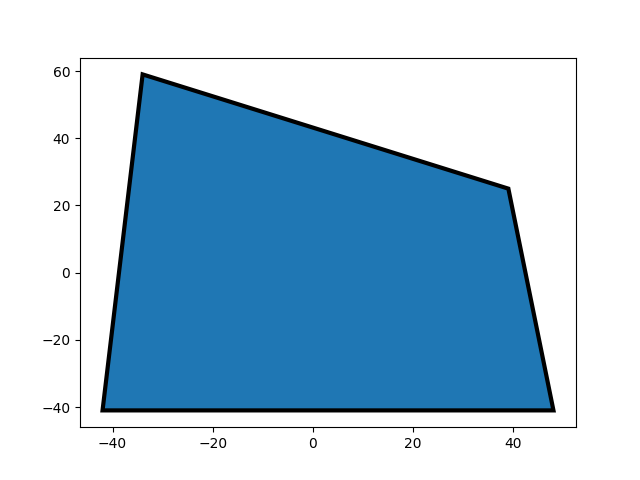

In [8]:
ch = convex_hull(points)

plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)
plt.show()

In [10]:
def antipodal_pairs(points):
    """
    Returns the antipodal pairs of a convex polygon. The points must be in
    a counterclockwise sequence.
    
    The format of the returned antipodal pairs is a list of (p, q) pairs, where p and q are indices that 
    correspond directly to indices of the points array that was passed to this function.
    
    The antipodal pairs (also called rotating calipers) procedure is described in further detail in Preparata
    and Shamos (1985).
    """
    res = []
    n = len(points)
    def _next(i):
        return (i + 1) % n
    def previous(i):
        return (i - 1) % n
    
    p = n - 1
    q = _next(p)
    while triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) > \
          triangle_signed_area(points[p], points[_next(p)], points[q]):
        q = _next(q)
        
    p0, q0 = 0, q

    while q != p0:
        p = _next(p)
        res.append((p, q))
        
        while triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) > \
              triangle_signed_area(points[p], points[_next(p)], points[q]):
            q = _next(q)
            
            if (p, q) != (q0, p0):
                res.append((p, q))
            else:
                break
        if triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) == \
           triangle_signed_area(points[p], points[_next(p)], points[q]):
            if (p, q) != (q0, n-1):
                res.append((p, _next(q)))
            else:
                break
                        
    return np.array(res)

def make_diameter_function(points):
    """
    Returns the piecewise diameter function of a convex polygon. The points must be in  a counterclockwise 
    sequence. This algorithm is adapted from pseudocode in Preparata and Shamos (1985)
    and was modified to return a piecewise diameter function as described in Goldberg (1993). As such,
    most of the code is identical to the antipodal_pairs function. The antipodal_pairs function is
    provided for plotting purposes and convenience. 
    
    The format of the piecewise function is a list of (m, l, i) tuples, where l and i describe a section
    of the piecewise diameter function in the form l*cos(theta-i). In the paper, the diameter is described
    as a series of l*sin(theta-i) functions, but here pi/2 is added to i, so they are functionally equivalent.
    m describes the minimum theta for which l*cos(theta-i) is valid, and the maximum angle (theta) is the m in 
    the following tuple in the list.
    
    The antipodal pairs (also called rotating calipers) procedure is described in further detail in Preparata
    and Shamos (1985).
    """
    res = []
    piecewise_diameter = []
    n = len(points)
    def _next(i):
        return (i + 1) % n
    def previous(i):
        return (i - 1) % n
    
    p = n - 1
    q = _next(p)
    while triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) > \
          triangle_signed_area(points[p], points[_next(p)], points[q]):
        q = _next(q)
        
    p0, q0 = 0, q

    while q != p0:
        p = _next(p)
        res.append((p, q))
        
        p1, p2 = points[p], points[q]
        initial_angle = get_angle(points[previous(p)], points[p])
        chord_length = np.linalg.norm(p2-p1)
        angle_max_length = get_angle(p1, p2) + np.pi/2
        # print(p1, p2, initial_angle, angle_max_length)
        
        piecewise_diameter.append((initial_angle, chord_length, angle_max_length))
        
        while triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) > \
              triangle_signed_area(points[p], points[_next(p)], points[q]):
            q = _next(q)
            
            # add to piecewise diameter function
            if (p, q) != (q0, p0):
                p1, p2 = points[p], points[q]
                initial_angle = get_angle(points[q], points[previous(q)])
                chord_length = np.linalg.norm(p2-p1)
                angle_max_length = get_angle(p1, p2) + np.pi/2
                # print(p1, p2, initial_angle, angle_max_length)
                
                piecewise_diameter.append((initial_angle, chord_length, angle_max_length))
                res.append((p, q))
            else:
                break
        if triangle_signed_area(points[p], points[_next(p)], points[_next(q)]) == \
           triangle_signed_area(points[p], points[_next(p)], points[q]):
            # TODO handle parallel edges
            # print('parallel', [points[p],points[_next(q)], [p, _next(q)]])
            if (p, q) != (q0, n-1):
                res.append((p, _next(q)))
            else:
                break
                        
    return piecewise_diameter

def get_angle(p1, p2):
    """Returns the angle of the vector from p1 to p2"""
    v = p2 - p1
    return np.arctan2(*v[::-1]) # % np.pi

<IPython.core.display.Javascript object>


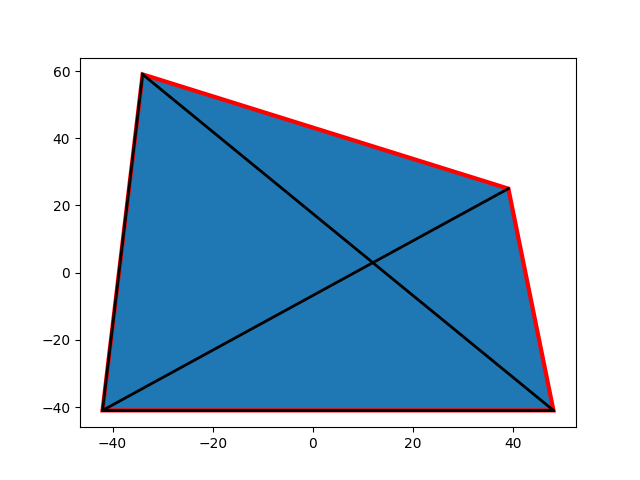

In [11]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='red', linewidth=3)
for p1, p2 in antipodal_pairs(ch):
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.show()

In [12]:
piecewise_diameter = make_diameter_function(ch)

def generate_range(piecewise_func, period, domain=(0, 2*np.pi)):
    """
    Given one period of a piecewise function and the period of the function, expands out the
    piecewise function so that it covers the domain.
    """
    one_period = piecewise_func[:]
    count = 1
    while piecewise_func[0][0] >= domain[0]:
        print(piecewise_func)
        shift = [(p[0] - period*count,) + p[1:] for p in one_period]
        piecewise_func = shift + piecewise_func
        count += 1
        
    count = 1
    while piecewise_func[-1][0] <= domain[1]:
        shift = [(p[0] + period*count,) + p[1:] for p in one_period]
        piecewise_func = piecewise_func + shift
        count += 1
    
    return piecewise_func

def generate_callable(piecewise_func):
    """
    Convenience function to generate a callable piecewise function based off piecewise_func.
    
    pecewise_func must be in the format of a diameter or radius function.
    """
    def func(theta):
        for i in range(0, len(piecewise_func)-1):
            if piecewise_func[i][0] <= theta < piecewise_func[i+1][0] or np.isclose(theta, piecewise_func[i][0]):
                return piecewise_func[i][1] * abs(math.cos(theta-piecewise_func[i][2]))
            
    return func

In [13]:
def find_extrema(piecewise_func, domain=(0, 2*np.pi)):
    """
    Returns the extrema of a piecewise function in the passed domain. The piecewise function must be
    in the format of a list of tuples as described in the antipodal_pairs method.
    Additionally, it must be passed to the generate_range function first.
    """
    func_callable = generate_callable(piecewise_func)
    # restrict the piecewise func to the proper range
    while piecewise_func[1][0] < domain[0]:
        piecewise_func = piecewise_func[1:]
    
    while piecewise_func[-1][0] > domain[1]:
        piecewise_func = piecewise_func[:-1]
        
    maxima = []
    for i in range(len(piecewise_func)):
        m, l, t = piecewise_func[i]
        lower_bound = max(domain[0], m)
        upper_bound = piecewise_func[i+1][0] if i != len(piecewise_func)-1 else domain[1]

        # need to get the inital angle within range. Since all sections of the piecewise
        # functions are abs(cos(t)), we can add/subtract pi until the intial angle is within
        # the approximate range
        while t - lower_bound > np.pi or np.isclose(t-lower_bound, np.pi):
            t -= np.pi
        while upper_bound - t > np.pi or np.isclose(upper_bound-t, np.pi):
            t += np.pi

        if lower_bound < t < upper_bound:
            maxima.append(t)
    
    minima = []
    
    minima_ranges = maxima[:]
    if not np.isclose(minima_ranges[0], domain[0]):
        minima_ranges.insert(0, domain[0])
    if not np.isclose(minima_ranges[-1], domain[1]):
        minima_ranges.append(domain[1])
        
    minima_candidates = np.array([p[0] for p in piecewise_func])
    
    for i in range(len(minima_ranges)-1):
        valid_points = minima_candidates[np.logical_and(minima_ranges[i] < minima_candidates, 
                                                        minima_candidates < minima_ranges[i+1])]
        valid_points = np.append(valid_points, [minima_ranges[i], minima_ranges[i+1]])
        minimum = min(valid_points, key=func_callable)
        minima.append(minimum)
    
    return maxima, minima

<IPython.core.display.Javascript object>


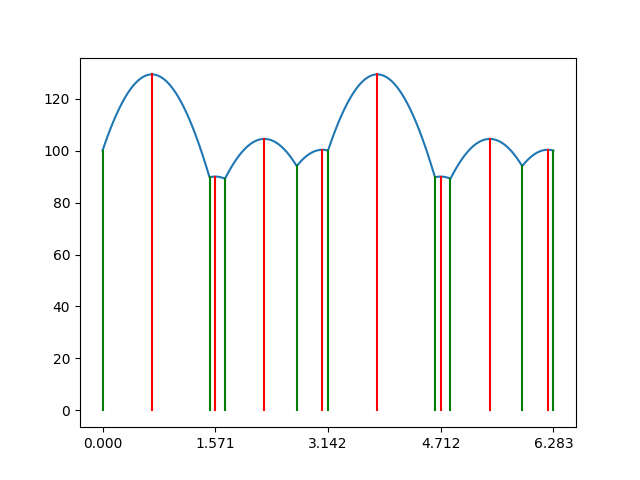

In [14]:
plot_function(piecewise_diameter, np.pi, (0, 2*np.pi))

In [15]:
def make_radius_function(points):
    """
    Returns the radius function for a convex polygon. 
    
    Return format is a list of (m, l, i) tuples in the same format as described in the diameter function
    generator. 
    """
    
    C_x, C_y = centroid(points)
    pieces = []
    for i in range(len(points)):
        p = points[i]
        prev_p = points[(i-1) % len(points)]
        
        x, y = p - prev_p
        min_angle = np.arctan2(y, x) # % (2*np.pi)
        
        l = p - (C_x, C_y)
        orth_angle = (np.arctan2(*reversed(l)) + np.pi/2) # % (2*np.pi)
        
        dist = np.linalg.norm(l)
        
        pieces.append((min_angle, dist, orth_angle))
        
    pieces.sort(key=lambda p: p[0])
    
    return pieces

<IPython.core.display.Javascript object>


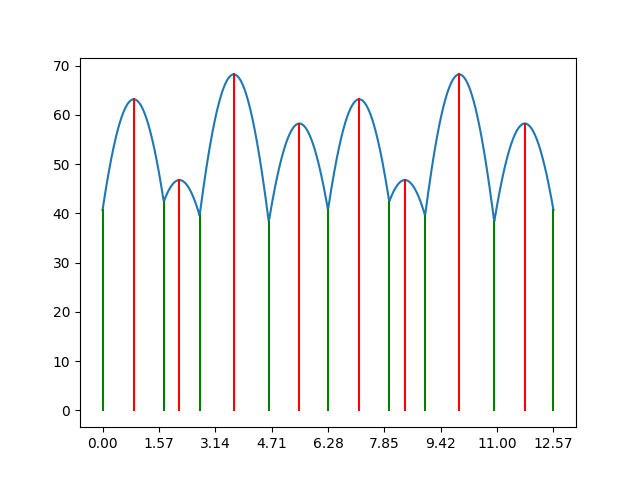

In [16]:
piecewise_radius = make_radius_function(ch)
plot_function(piecewise_radius, 2*np.pi, (0, 4*np.pi))

In [17]:
def make_transfer_function(piecewise_func, domain=(0, 2*np.pi)):
    """
    Makes a transfer function (a squeeze or push function). Return format is _not_ the same
    as a diameter or radius function. If piecewise_func is a radius function, then the output is
    a push function. If piecewise_func is a diameter function, then the output is the 
    squeeze function.
    
    Return format is the a list of (a, b, t) tuples, where [a, b) describe the domain in which
    the output is t.
    """
    maxima, minima = find_extrema(piecewise_func, domain=domain)
    minima_ranges = maxima[:]
    if not np.isclose(minima_ranges[0], domain[0]):
        minima_ranges.insert(0, domain[0])
    if not np.isclose(minima_ranges[-1], domain[1]):
        minima_ranges.append(domain[1])
    
    piecewise_transfer = []
    
    for i in range(len(minima_ranges)-1):
        a, b, t = minima_ranges[i], minima_ranges[i+1], minima[i]
        piecewise_transfer.append((a, b, t))
        
    return piecewise_transfer
    
    

def make_transfer_callable(piecewise_transfer_func, domain=(0, 2*np.pi)):
    """
    Makes a callable transfer function (a squeeze or a push function) for convenience and plotting purposes. 
    In practice, it is easier to work directly with the extrema of each function. piecewise_transfer_func
    must be the output from either make_transfer_function or make_push_grasp_function.
    
    Returns a callable transfer function that is valid over the passed domain.
    """
    
    def transfer_func(theta):
        for i in range(len(piecewise_transfer_func)-1):
            if piecewise_transfer_func[i][0] <= theta < piecewise_transfer_func[i][1] or \
                np.isclose(piecewise_transfer_func[i][0], theta):
                return piecewise_transfer_func[i][2]

        return domain[1]
    
    return transfer_func

<IPython.core.display.Javascript object>


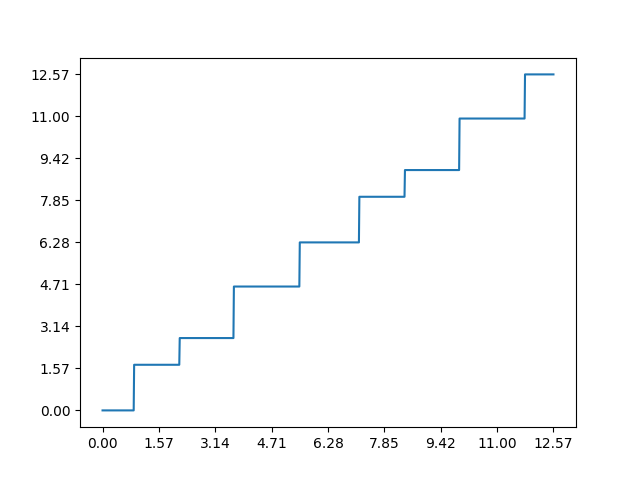

In [18]:
_domain = (0, 4*np.pi)
piecewise_diameter_range = generate_range(piecewise_diameter, period=np.pi, domain=_domain)
piecewise_radius_range = generate_range(piecewise_radius, period=2*np.pi, domain=_domain)

push_func = make_transfer_function(piecewise_radius_range, domain=_domain)
squeeze_func = make_transfer_function(piecewise_diameter_range, domain=_domain)

plot_transfer_function(push_func, domain=_domain)

<IPython.core.display.Javascript object>


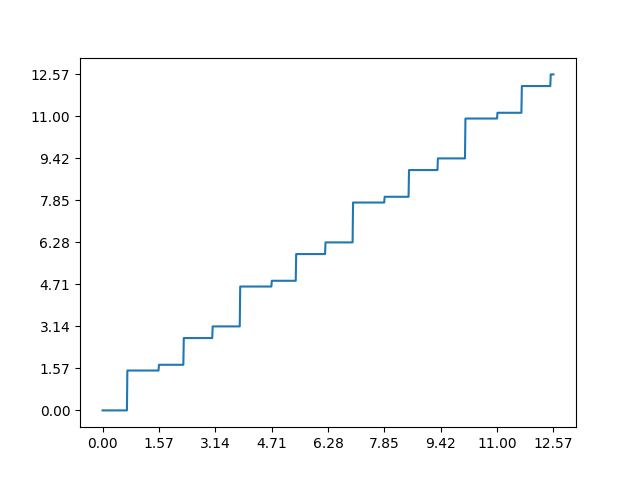

In [19]:
plot_transfer_function(squeeze_func, domain=_domain)

In [21]:
def make_push_grasp_function(piecewise_diameter, piecewise_radius, domain=(0, 2*np.pi)):
    """
    Returns a push-grasp function as defined in Goldberg (1993) by composing the push and squeeze functions
    together, i.e. push_grasp(theta) = squeeze(push(theta)).
    """
    push_func = make_transfer_function(piecewise_radius, domain=domain)
    squeeze_func = make_transfer_function(piecewise_diameter, domain=domain)
    
    push_callable = make_transfer_callable(push_func, domain=domain)
    squeeze_callable = make_transfer_callable(squeeze_func, domain=domain)
    
    push_grasp_func = []
    for a, b, t in push_func:
        next_t = squeeze_callable(t)
        if len(push_grasp_func) > 0 and np.isclose(next_t, push_grasp_func[-1][-1]):
            prev = push_grasp_func.pop()
            next_piece = (prev[0], b, next_t)
        else:
            next_piece = (a, b, next_t)
            
        push_grasp_func.append(next_piece)
        
    return push_grasp_func

<IPython.core.display.Javascript object>


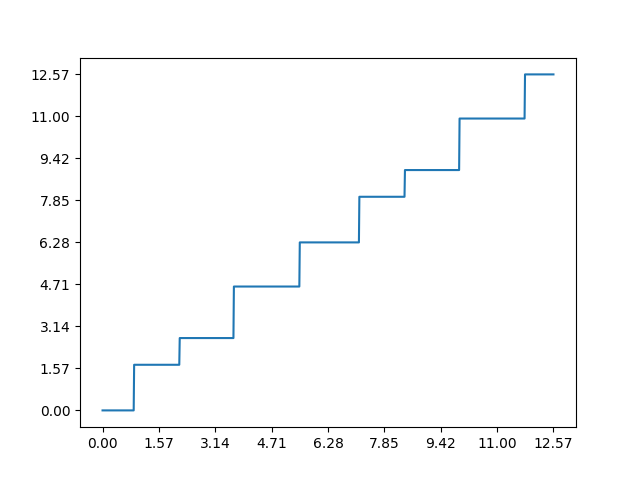

In [22]:
push_grasp_func = make_push_grasp_function(piecewise_diameter_range, piecewise_radius_range, domain=_domain)

plot_transfer_function(push_grasp_func, domain=_domain)

In [24]:
push_grasp_func

[(0, 0.8710076127351551, 0.0),
 (0.8710076127351551, 2.142940900973857, 1.7063240407803972),
 (2.142940900973857, 3.658006522432628, 2.705715681182408),
 (3.658006522432628, 5.4856103320980925, 4.632558994672452),
 (5.4856103320980925, 7.154192919914742, 6.283185307179586),
 (7.154192919914742, 8.426126208153443, 7.9895093479599835),
 (8.426126208153443, 9.941191829612215, 8.988900988361994),
 (9.941191829612215, 11.768795639277679, 10.915744301852039),
 (11.768795639277679, 12.566370614359172, 12.566370614359172)]

In [25]:
class Interval:
    """
    Implementation of a s-interval as defined in Goldberg (1993). 
    
    abs(interval) returns the lebesgue measure of the interval
    """
    def __init__(self, a, b, image):
        self.a = a
        self.b = b
        self.image = image
        
    def __abs__(self):
        return self.b - self.a
    
    def __repr__(self):
        return f'Interval({(self.a)}, {(self.b)}, {repr(self.image)})'
        
        # return f'Interval({round(self.a, 3)}, {round(self.b, 3)}, {repr(self.image)})'
    
class Image:
    """
    Implementation of an s-image as defined in Goldberg (1993).
    
    abs(image) returns the lebesgue measure of the image.
    """
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __abs__(self):
        return self.b - self.a
    
    def __repr__(self):
        return f'Image({round(self.a, 3)}, {round(self.b, 3)})'

In [26]:
def generate_intervals(transfer_func):
    """
    Returns a list of s-intervals used to recover the plan using the algorithm described
    in Goldberg (1993). 
    
    transfer_func must be either a squeeze or a push-grasp function.
    """
    
    intervals = []
    
    # Step 2 of algorithm: find widest single step
    max_single_step = Interval(0, 0, None)
    for a, b, t in transfer_func:
        if b-a > abs(max_single_step) and not np.isclose(b-a, abs(max_single_step)):
            max_single_step = Interval(a, b, Image(t, t))
            
    intervals.append(max_single_step)
    
    # For step 3, we need to generate all possible s-intervals with nonzero measure
    all_intervals = []
    for i in range(len(transfer_func)-1):
        for j in range(i+1, len(transfer_func)):
            image = Image(transfer_func[i][2], transfer_func[j][2])
            interval = Interval(transfer_func[i][0], transfer_func[j][1], image)
            all_intervals.append(interval)
    
    # For step 3, we also need to compute the periodicity in the transfer (squeeze or push-grasp)
    # function, which is the termination condition for the loop in step 3 of the algorithm.
    T = transfer_func_periodicity(transfer_func)

    # Step 3: Generate list of intervals
    while not np.isclose(abs(intervals[-1]), T):
        
        # Part 1: get all intervals with a smaller image than the width of the last interval
        valid_ints = []
        for i in all_intervals:
            if abs(i.image) < abs(intervals[-1]):
                valid_ints.append(i)
                
        # pprint.pprint(valid_ints)
        
        # Part 2: set the next interval to the widest such interval
        widest = valid_ints[0]
        for i in valid_ints[1:]:
            if abs(i) > abs(widest):
                widest = i
            elif np.isclose(abs(i), abs(widest)) and \
                abs(i.image) < abs(widest.image) and \
                not np.isclose(abs(i.image), abs(widest.image)):
                # this block deals with ties for the largest interval by picking the interval
                # with the smallest image. 
                widest = i
                
        all_intervals.remove(widest)
        intervals.append(widest)
    
    return intervals
    
def period_from_r_fold(r):
    """
    Returns the period of a polygon's squeeze function given the n-fold (called r-fold in the paper) 
    rotational symmetry of the polygon. Equation is given in Goldberg (1993).
    """
    return 2*np.pi/(r*(1+r%2))

def transfer_func_periodicity(transfer_func, max_r=8):
    """
    Returns the period of the passed transfer function.
    
    For objects with no rotational symmetry, the period for the squeeze function will be pi
    and push-grasp function will be 2pi. 
    """
    res_T = 2*np.pi
    
    transfer_func_callable =  make_transfer_callable(transfer_func, domain=(0, 2*np.pi))
    
    x = np.linspace(0, 2*np.pi, 1000)
    y = np.array([transfer_func_callable(t) for t in x])
    for r in range(2, max_r+1):
        T = period_from_r_fold(r)
        
        x_shift = (x + T) % (2*np.pi)
        y_shift = np.array([transfer_func_callable(t) for t in x_shift]) % (2*np.pi)
        
        if all(np.isclose((y+T)%(2*np.pi), y_shift)):
            res_T = T
            
    return res_T

In [27]:
ints = generate_intervals(push_grasp_func)
ints

[Interval(3.658006522432628, 5.4856103320980925, Image(4.633, 4.633)),
 Interval(3.658006522432628, 7.154192919914742, Image(4.633, 6.283)),
 Interval(3.658006522432628, 8.426126208153443, Image(4.633, 7.99)),
 Interval(3.658006522432628, 9.941191829612215, Image(4.633, 8.989))]

In [28]:
def generate_plan(intervals):
    """
    Generates a plan from a list of intervals using the method outlined in Goldberg (1993). 
    """
    
    plan = [0]
    
    for i in reversed(range(len(intervals)-1)):
        eps = (abs(intervals[i]) - abs(intervals[i+1].image))/2
        alpha = intervals[i+1].image.a - intervals[i].a - eps + plan[-1]
        plan.append(alpha)
        
    return plan

In [29]:
[a * (180/np.pi) for a in generate_plan(ints)]

[0.0, 44.04118164786738, 95.89010637702634, 146.65781812242815]